# Adaptive PDE discretizations on Cartesian grids
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Walls and obstacles

We compute minimal paths in domains featuring obstacles, and check that the CPU and GPU codes provide consistent results.

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Isotropic metrics](#1.-Isotropic-metrics)
  * [2. Curvature penalized metrics](#2.-Curvature-penalized-metrics)
  * [3. Centre Pompidou](#3.-Centre-Pompidou)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Walls_GPU','Repro'))

In [2]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
from agd.Plotting import savefig,imread; #savefig.dirName = 'Figures/Walls_GPU'; savefig.dpi=150
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity

from agd.ExportedCode.Notebooks_Repro.Isotropic_GPU import RunCompare

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
import matplotlib
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
Eikonal.dictIn.default_mode = 'gpu'

### 0.1 Additional configuration

Run large problem instances (computation time may become a bit longer).

In [5]:
large_instances=False

## 1. Isotropic metrics

In [6]:
n=201
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0,0],
    'exportValues':1,
    'cost':1,
})
hfmIn.SetRect([[-1,1],[0,1]],dimx=n+1,sampleBoundary=True)
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

In [7]:
X = hfmIn.Grid()
walls = np.logical_and(X[0]==X[0,int(2*n/3)],X[1]<=2./3.)
hfmIn['walls']=walls

In [8]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0 seconds, and 16 iterations.
Post-Processing


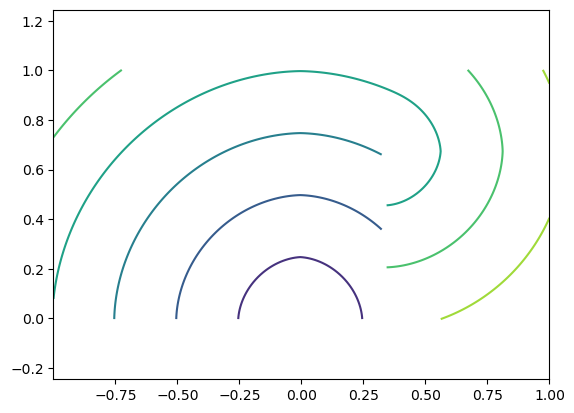

In [9]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'])

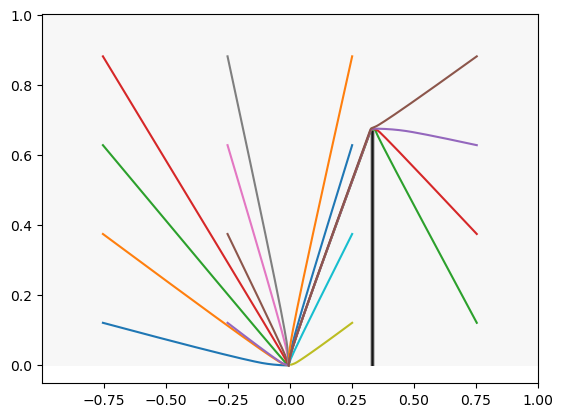

In [10]:
plt.contourf(*X,walls,cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

In [11]:
assert all(stop=='AtSeed' for stop in hfmOut['geodesic_stopping_criteria'])

## 2. Curvature penalized metrics

In [12]:
n = 300 if large_instances else 100 
nTheta = 96 if large_instances else 64
hfmIn = Eikonal.dictIn({
    'model':'Elastica2',
    'seed':[0.,0.,np.pi],
    'exportValues':1,
    'cost':1,
    'xi':0.4,
#    'count_updates':True,
#    'bound_active_blocks':True,
})
hfmIn.SetRect([[-1,1],[0,1]],dimx=n+1,sampleBoundary=True)
hfmIn.nTheta = nTheta
hfmIn.SetUniformTips((4,4,4))

In [13]:
X = hfmIn.Grid()
walls = np.logical_and(X[0]==X[0,int(2*n/3)],X[1]<=2./3.)
hfmIn['walls']=walls

In [14]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.10487675666809082 seconds, and 168 iterations.
Post-Processing


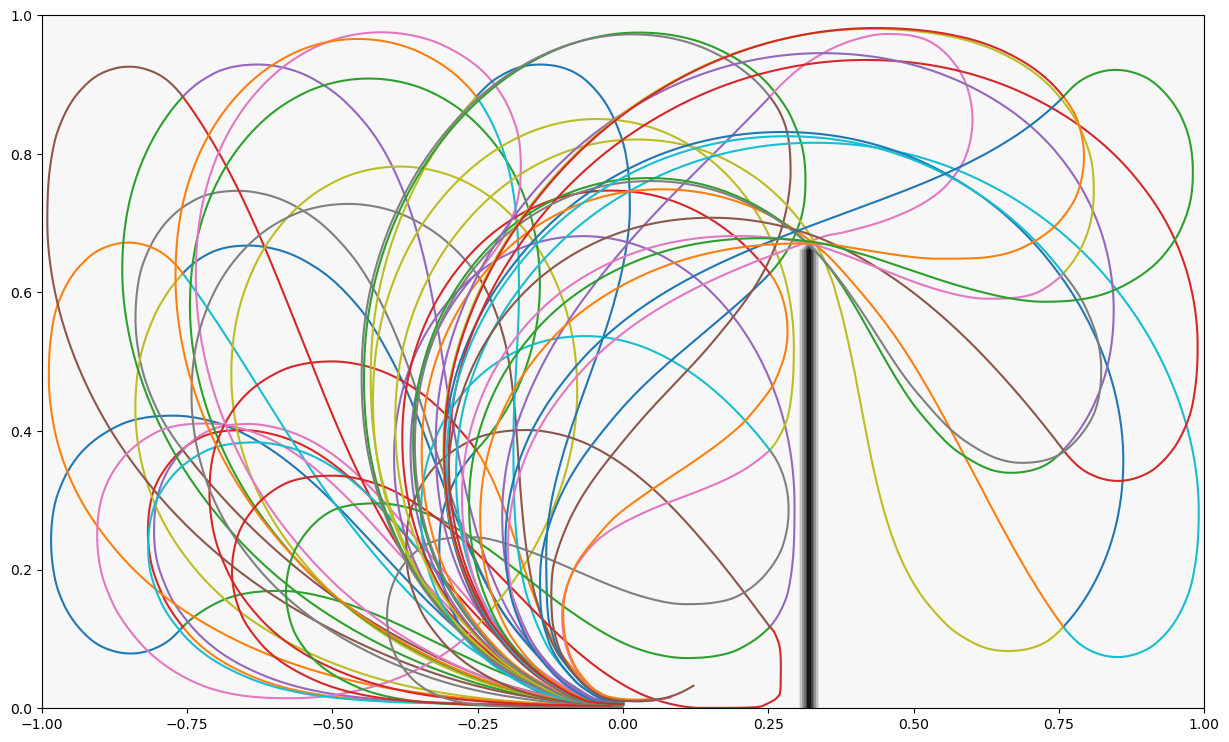

In [15]:
plt.figure(figsize=(15,9)) 
plt.contourf(*X[:2,:,:,0],walls[:,:,0],cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo[:2])

All the geodesics end at the seed, except one whose tip is very close to the wall, with an initial orientation headed straight into it. Its stopping criterion is 'InWall'.

In [16]:
assert all(stop in ('AtSeed','InWall','PastSeed') for stop in hfmOut['geodesic_stopping_criteria'])

## 3. Centre Pompidou

<!--- # Non resized image
seeds = np.array([[80,170],[80,290]])
seeds[:,0]-=65; seeds[:,1]-=68

tips = np.array([
        [369.4, 252.2, 285., 418.6, 479.8, 687.2, 745.8, 740.4, 593.8, 558.6,
        599.2, 497.2, 495.8, 427.2, 339., 264.6, 242.4, 354.6, 191.6, 
        178.8, 105.8, 124., 127., 419.2],[482.5, 354.5, 478., 488., 487.5, 
        478., 502.5, 300., 225.5, 378., 475.5, 81., 127.5, 128., 111., 108.,
        176.5, 290.5, 110., 252.5, 428.5, 494., 353., 421.]]).T
tips[:,0]-=65; tips[:,1]-=68
--->

<!--- # Non oriented tips
#    'seeds':[[ 15, 102,0],[ 15, 222,0]],

    'tips_Unoriented':[
        [  304,   414],[  187,   286],[  220,   410],[  354,   420],[  415,   420],
        [  622,   410],[  681,   434],[  675,   232],[  529,   158],[  494,   310],
        [  534,   408],[  432,    13],[  431,  59.5],[  362,    60],[  274,    43],
        [  200,    40],[  177,   108],[  290,   222],[  127,    42],[  114,   184],
        [ 40.8,   360],[   59,   426],[   62,   285],[  354,   353]],

--->

<!--- Display tip number
hfmIn['model'] = 'Dubins2'
hfmIn['xi']=50
hfmOut = hfmIn.Run()
val = hfmOut['values']
hfmOut['values'] = np.minimum(val,900)
fig = show()
for i,tip in enumerate(hfmIn['tips_Unoriented']):
    plt.text(*tip,i)
    plt.scatter(*tip)
--->

In [9]:
# https://www.netclipart.com/isee/wTowwJ_black-white-cartoon-drawings-how-to-draw-a/
im = imread("/Notebooks_FMM/TestImages/centre_pompidou_800x546.png")
im = im[68:515,65:770]
walls = np.logical_not(np.logical_and(np.logical_and(im[:,:,0]==0,im[:,:,1]==0),im[:,:,2]==1))
walls = cp.asarray(walls.T)

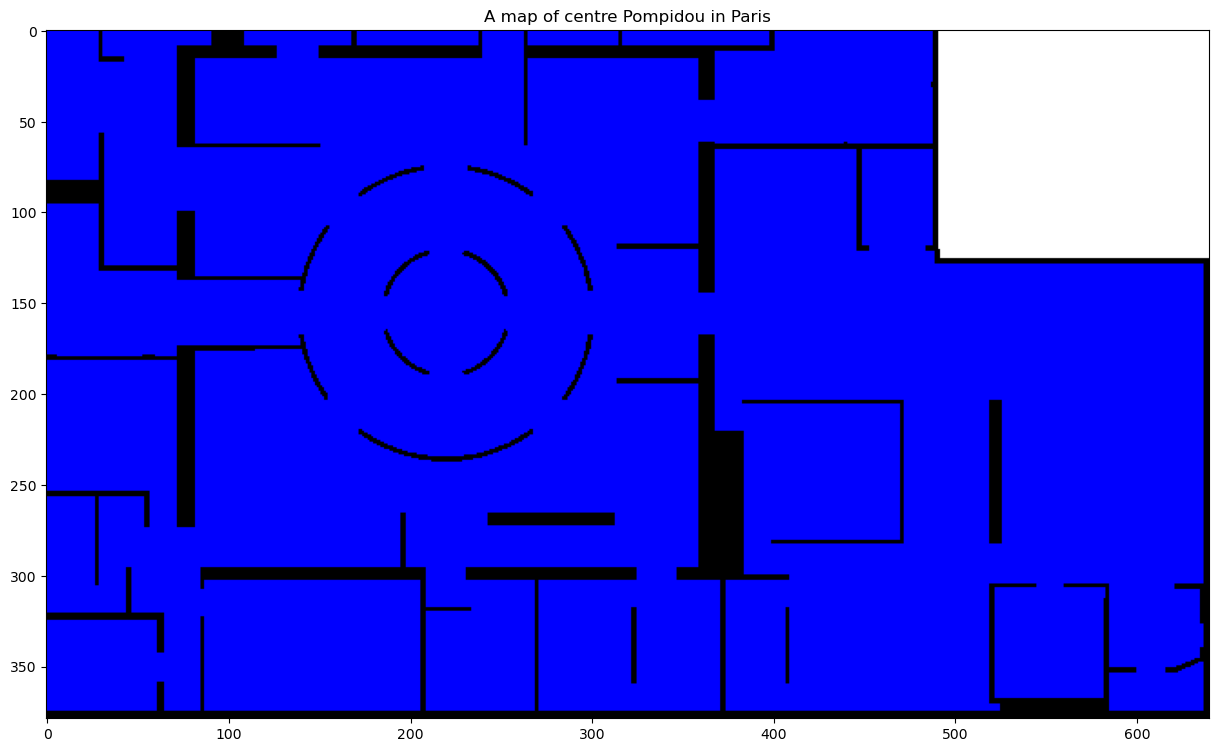

In [10]:
plt.figure(figsize=(15,10))
plt.title("A map of centre Pompidou in Paris")
plt.imshow(im[68:515,65:770]);

In [93]:
pi=np.pi
hfmIn = Eikonal.dictIn({
    'model':'ReedsShepp2',
    'xi':60, #Typical radius of curvature, here in pixels
    'walls':walls,
    'dims':walls.shape,
    'origin':(0,0),
    'gridScale':1,
    'seeds_Unoriented':[[ 15, 102],[ 15, 222]],
    'tips':[
        [304,414,pi/2],[187,286,0],[220,410,0],[354,420,pi/2],[415,420,0],
        [622,410,pi/2],[681,434,pi/2],[675,232,-3*pi/4],[529,158,-pi/2],[494,310,0],
        [534,408,pi],[432, 13,pi],[431, 59,0],[362, 60,pi/2],[274, 43,pi],
        [200, 40,-pi/2],[177,108,pi],[290,222,-pi/2],[127, 42,-pi/2],[114,184,pi/2],
        [41, 360,pi],[ 59,426,pi],[ 62,285,pi],[354,353,0.]],
    'exportValues':True,                   
})
hfmIn.nTheta=60

In [94]:
aX0,aX1,_ = hfmIn.Axes()
X = np.meshgrid(aX0,aX1,indexing='ij')

In [95]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 1.0282509326934814 seconds, and 245 iterations.
Post-Processing


In [100]:
def show():
    """Displays the geodesics, and their tips, as stored in hfmIn, gpuOut"""
    fig = plt.figure(figsize=[17,12])
    
    # Show projections of geodesics and their tips
    for geo in hfmOut['geodesics']: plt.plot(*geo[:2]) #_Unoriented
    
    vals = np.where(walls,np.inf,np.min(hfmOut['values'],axis=2))
    plt.contourf(*X,vals,cmap='Greys',levels=20)
    plt.axis('equal')
    
    # No axes labels, equal scales
    plt.axis('equal')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_facecolor('black')
    
    return fig

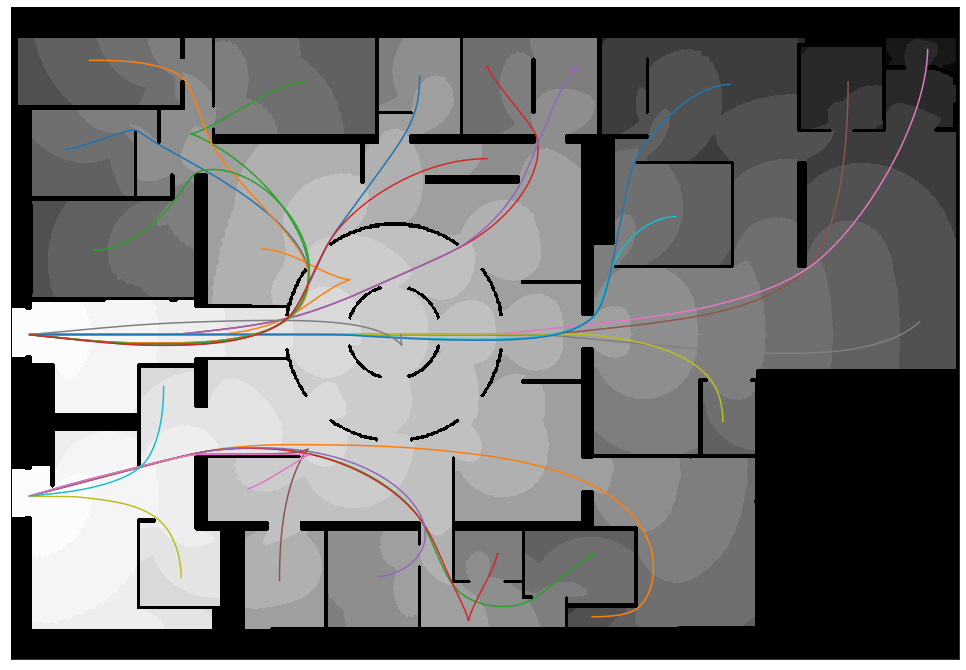

In [101]:
fig=show()
savefig(fig,'ReedsShepp.png')

In [102]:
hfmIn['model'] = 'ReedsSheppForward2'
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.43384313583374023 seconds, and 348 iterations.
Post-Processing


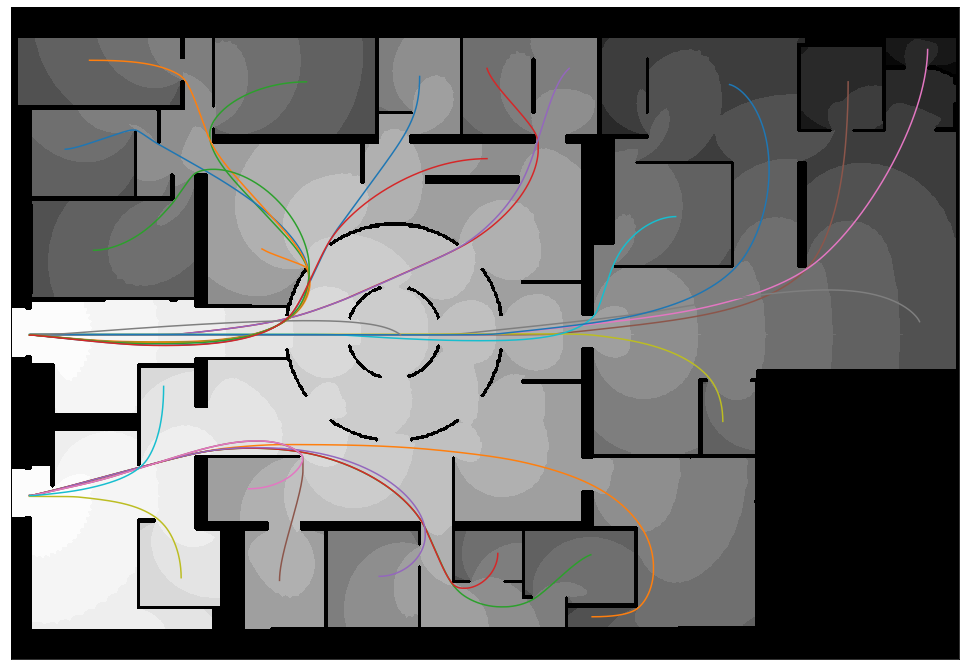

In [103]:
fig = show()
savefig(fig,'ReedsSheppForward.png')

In [104]:
hfmIn['model'] = 'Elastica2'
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 2.817537546157837 seconds, and 696 iterations.
Post-Processing


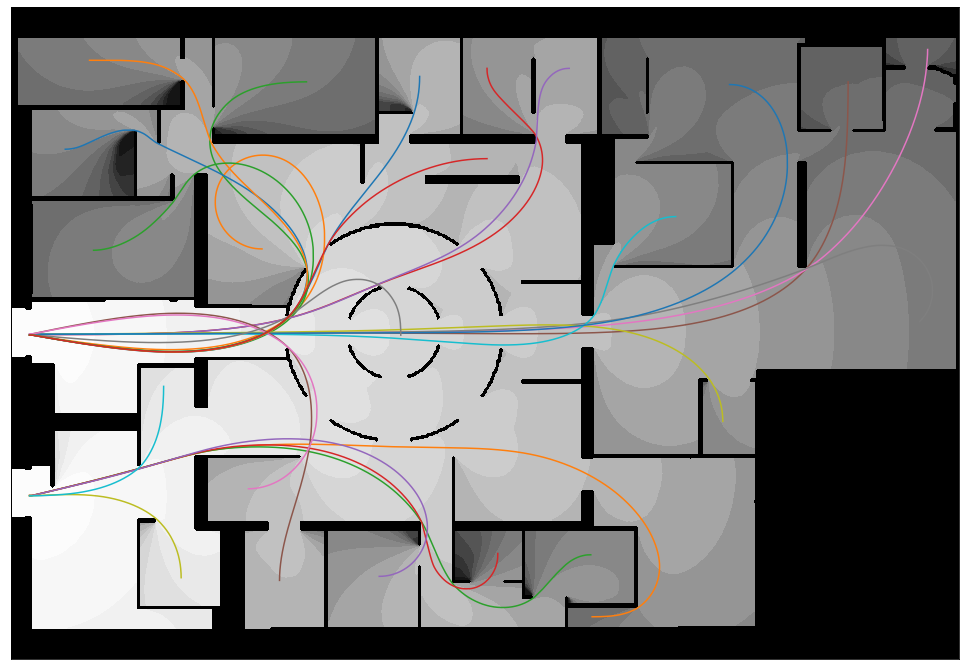

In [105]:
fig = show()
savefig(fig,'Elastica.png')

In [106]:
hfmIn['model'] = 'Dubins2'
hfmIn['xi']=50
hfmOut = hfmIn.Run()
val = hfmOut['values']

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 1.1379880905151367 seconds, and 346 iterations.
Post-Processing


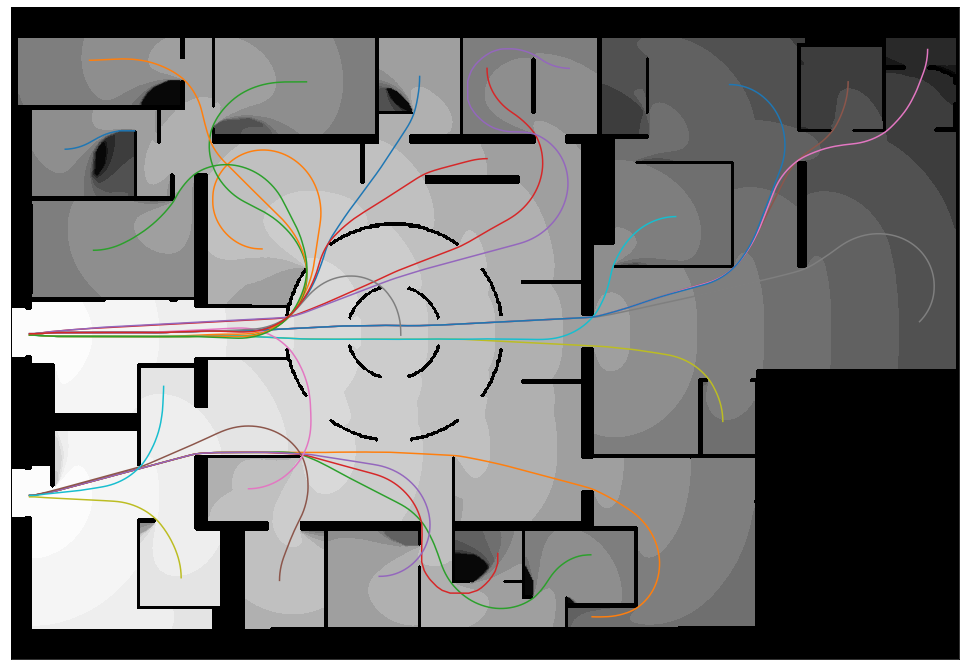

In [107]:
hfmOut['values'] = np.minimum(val,900)
fig = show()
savefig(fig,'Dubins.png')